In this notebook, we examined the differences in connectivity changes (Incongruent vs Congruent) of both tasks, concentrating on the characteristics at the intrinsic network level.

In [1]:
from scipy.spatial.distance import squareform
from nilearn.image import load_img
import pandas as pd
from scipy import stats
import numpy as np
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt

final_subjects = np.loadtxt("../data/subjects_intersect_motion_035.txt")
n_subjects = len(final_subjects)
print(n_subjects)

n_scans = 280 #

rsn_networks = pd.read_csv("../data/atlases/shen_268_parcellation_networklabels.csv").Network
rsn_networks

rsn_names = ["MF", "FP", "DM", "SC", "MT", "V1", "V2", "VA"]


z_edge_stroop = load_img("../results/second-level/edge_gsr/shen/task-stroop/Incongruent-Congruent/z_score.nii.gz")
z_edge_stroop = squareform(np.squeeze(z_edge_stroop.get_fdata()), checks=False)
edge_sig_stroop  = multipletests(stats.norm.sf(abs(z_edge_stroop))*2, method="bonferroni")[0]

z_edge_msit = load_img("../results/second-level/edge_gsr/shen/task-msit/Incongruent-Congruent/z_score.nii.gz")
z_edge_msit = squareform(np.squeeze(z_edge_msit.get_fdata()), checks=False)
edge_sig_msit  = multipletests(stats.norm.sf(abs(z_edge_msit))*2, method="bonferroni")[0]

242


In [3]:
def extract_within_network(net):
    rsn_within = []
    for ii in range(1, 9):
        rsn_links = net[rsn_networks==ii,:][:,rsn_networks==ii]
        rsn_within.append(squareform(rsn_links, checks=False))
    return rsn_within

def prop_links(net):
    prop_mat = np.zeros((8,8))
    sig_elems = np.sum(net)
    net = squareform(net)
    for ii in range(1, 9):
        for jj in range(ii, 9):
            mat = net[rsn_networks==ii,:][:,rsn_networks==jj]
            
            if ii==jj:
                prop_mat[ii-1,jj-1] = np.sum(squareform(mat, checks=False))
                size = len(squareform(mat, checks=False))
                prop_mat[ii-1,jj-1] /=size
            else:
                prop_mat[ii-1,jj-1] = np.sum(mat)
                prop_mat[ii-1,jj-1] /= mat.size
                
            prop_mat[jj-1, ii-1] = prop_mat[ii-1, jj-1]
    return prop_mat

In [4]:
# Generate a mask for the upper triangle
mask_up = np.triu(np.ones((8,8), dtype=bool), k=1)
mask_up
# Generate a mask for the upper triangle
mask_down = np.tril(np.ones((8,8), dtype=bool), k=-1)
mask_down

array([[False, False, False, False, False, False, False, False],
       [ True, False, False, False, False, False, False, False],
       [ True,  True, False, False, False, False, False, False],
       [ True,  True,  True, False, False, False, False, False],
       [ True,  True,  True,  True, False, False, False, False],
       [ True,  True,  True,  True,  True, False, False, False],
       [ True,  True,  True,  True,  True,  True, False, False],
       [ True,  True,  True,  True,  True,  True,  True, False]])

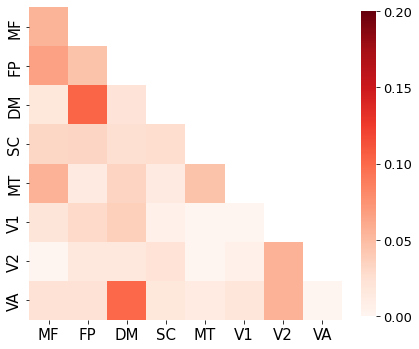

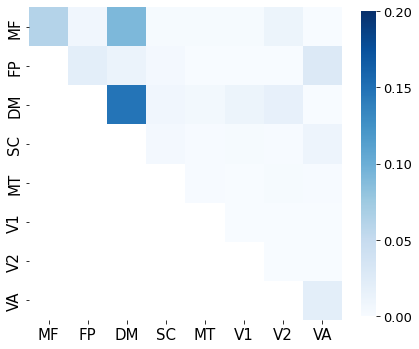

In [37]:
# Proportion of significant links (STROOP)

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(prop_links((z_edge_stroop>0)*edge_sig_stroop), mask=mask_up, 
            cmap=plt.cm.Reds, square=True,  
            xticklabels=rsn_names, yticklabels=rsn_names, cbar_kws={"shrink": .8}, vmin=0, vmax=0.2)
plt.tick_params(labelsize=15)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0., 0.05, 0.1, 0.15, 0.2])
cbar.ax.tick_params(labelsize=13)
plt.savefig("../plots/rsn_proportion_pos_stroop.svg", dpi=300)
plt.savefig("../plots/rsn_proportion_pos_stroop.png", dpi=300)
plt.savefig("../plots/rsn_proportion_pos_stroop.pdf", dpi=300)

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(prop_links((z_edge_stroop<0)*edge_sig_stroop), mask=mask_down, cmap=plt.cm.Blues, square=True,  
            xticklabels=rsn_names, yticklabels=rsn_names, cbar_kws={"shrink": .8}, vmin=0, vmax=0.2)
plt.tick_params(labelsize=15)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0., 0.05, 0.1, 0.15, 0.2])
cbar.ax.tick_params(labelsize=13)
plt.savefig("../plots/rsn_proportion_neg_stroop.svg", dpi=300)
plt.savefig("../plots/rsn_proportion_neg_stroop.png", dpi=300)
plt.savefig("../plots/rsn_proportion_neg_stroop.pdf", dpi=300)


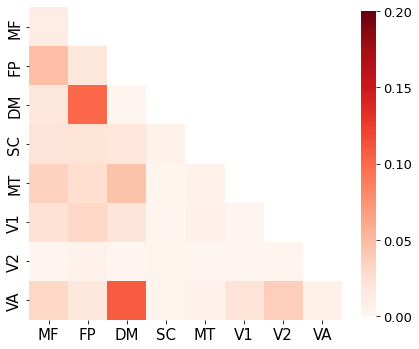

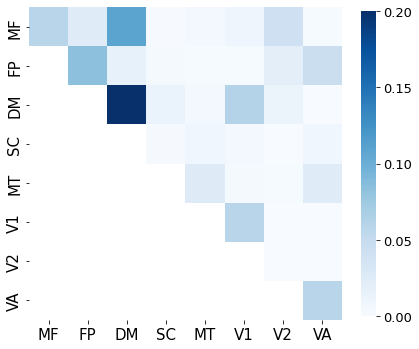

In [38]:
# Proportion of significant links (MSIT)

fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(prop_links((z_edge_msit>0)*edge_sig_msit), mask=mask_up, 
            cmap=plt.cm.Reds, square=True,  
            xticklabels=rsn_names, yticklabels=rsn_names, cbar_kws={"shrink": .8}, vmin=0, vmax=0.2)
plt.tick_params(labelsize=15)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0., 0.05, 0.1, 0.15, 0.2])
cbar.ax.tick_params(labelsize=13)
plt.savefig("../plots/rsn_proportion_pos_msit.svg", dpi=300)
plt.savefig("../plots/rsn_proportion_pos_msit.png", dpi=300)
plt.savefig("../plots/rsn_proportion_pos_msit.pdf", dpi=300)


fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(prop_links((z_edge_msit<0)*edge_sig_msit), mask=mask_down, cmap=plt.cm.Blues, square=True,  
            xticklabels=rsn_names, yticklabels=rsn_names, cbar_kws={"shrink": .8}, vmin=0, vmax=0.2)
plt.tick_params(labelsize=15)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0., 0.05, 0.1, 0.15, 0.2])
cbar.ax.tick_params(labelsize=13)
plt.savefig("../plots/rsn_proportion_neg_msit.svg", dpi=300)
plt.savefig("../plots/rsn_proportion_neg_msit.png", dpi=300)
plt.savefig("../plots/rsn_proportion_neg_msit.pdf", dpi=300)

Show that both tasks have a different concentration of negative and positive links

In [154]:
thr_stroop = np.percentile(abs(z_edge_stroop), 99.)
thr_msit = np.percentile(abs(z_edge_msit), 99.)

In [162]:
prop_table = [[sum(z_edge_stroop[abs(z_edge_stroop)>thr_stroop]>0), 
                     sum(z_edge_stroop[abs(z_edge_stroop)>thr_stroop]<0)],
                    [sum(z_edge_msit[abs(z_edge_msit)>thr_msit]>0), 
                     sum(z_edge_msit[abs(z_edge_msit)>thr_msit]<0)]]
print(prop_table)
stats.fisher_exact(prop_table)

[[302, 56], [211, 147]]


(3.7571090047393363, 4.000785120188315e-14)

In [149]:
prop_table = [[sum(z_edge_stroop[edge_sig_stroop]>0), 
                     sum(z_edge_stroop[edge_sig_stroop]<0)],
                    [sum(z_edge_msit[edge_sig_msit]>0), 
                     sum(z_edge_msit[edge_sig_msit]<0)]]
print(prop_table)
stats.fisher_exact(prop_table)


[[979, 249], [595, 481]]


(3.1784212480172793, 2.2181419340122896e-36)

In [163]:
print(sum(edge_sig_stroop))
print(sum(edge_sig_msit))

1228
1076
